## Experiment to Visualize LFP Decision Boundaries on Toy Data

### Imports

In [1]:
import copy
import os
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from experiment_utils.data import dataloaders as dataloaders
from experiment_utils.data import datasets as datasets
from experiment_utils.data import transforms as transforms
from experiment_utils.evaluation import evaluate as evaluate
from experiment_utils.model import models as models
from experiment_utils.utils.utils import register_backward_normhooks
from lfprop.propagation import propagator_lxt as propagator
from lfprop.rewards import rewards as rewards

### Experiment Variables

In [2]:
dataset_name = "blobs"  # swirls, circles, blobs # DONE: none
n_channels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
lr = 1.0
momentum = 0.0
reward_names = ["maximizesingleneuronreward", "minimizesingleneuronreward"]
loss_names = ["maximizesingleneuronloss", "minimizesingleneuronloss"]
norm_backward = False
epochs = 10
n_datasets = 1
datasample_versions = [[([[1.0, 1.0]], [1])], [([[1.0, 1.0]], [1])]]
weight_initializations = [(0.5, 0.5), (-1.0, -1.0)]

savepath = "<path to save results in>"
data_path = "<path where dataset is saved>"

retrain_models = True
redraw_data = True

### Training Utility

In [3]:
class SingleNeuronModel(torch.nn.Module):
    """
    SingleNeuronModel
    """

    def __init__(self, n_channels, activation_kwargs=None):
        super().__init__()

        if activation_kwargs is None:
            activation_kwargs = {}

        # Classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(n_channels, 1, bias=False),
        )
        self.act = torch.nn.SiLU()

    def forward(self, x):
        """
        Forwards input through network
        """

        # Forward through network
        x = torch.flatten(x, 1)
        self.pre_act_x = self.classifier(x)
        self.post_act_x = self.act(self.pre_act_x)

        # Return output
        return self.post_act_x

In [4]:
class Trainer:
    def __init__(
        self,
        model,
        train_data,
        optimizer,
        criterion,
        device,
        lfp_composite=None,
        norm_backward=False,
    ):
        self.model = model
        self.train_data = train_data
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.lfp_composite = lfp_composite
        self.norm_backward = norm_backward
        self.global_epoch = 0
        self.global_step = 0

        self.param_log = []
        self.pre_act_output_log = []
        self.post_act_output_log = []

    def grad_step(self, inputs, labels):
        # Backward norm
        if self.norm_backward:
            norm_handles = register_backward_normhooks(self.model)
        else:
            norm_handles = []

        self.model.train()
        with torch.enable_grad():
            self.optimizer.zero_grad()
            out = self.model(inputs)

            reward = self.criterion(out, labels)
            reward.backward()

            self.optimizer.step()

        self.model.eval()

        for handle in norm_handles:
            handle.remove()

        self.global_step += 1

    def lfp_step(self, inputs, labels):
        self.model.train()

        with torch.enable_grad():
            self.optimizer.zero_grad()
            with self.lfp_composite.context(self.model) as modified:
                inputs = inputs.detach().requires_grad_(True)
                outputs = modified(inputs)

                # Calculate reward
                # Do like this to avoid tensors being kept in memory
                reward = torch.from_numpy(self.criterion(outputs, labels).detach().cpu().numpy()).to(device)

                # Write LFP Values into .grad attributes
                input_reward = torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]

                for name, param in self.model.named_parameters():
                    param.grad = -param.feedback

                self.optimizer.step()

        self.model.eval()

        self.global_step += 1

    def train(
        self,
        epochs,
        verbose=False,
        savepath=None,
        savename="ckpt",
        saveappendage="last",
        fromscratch=False,
    ):
        if not fromscratch and savepath:
            self.load(savepath, savename, saveappendage)

        if verbose:
            (inputs, labels) = self.train_data[0]
            inputs = torch.tensor(inputs).to(device)
            labels = torch.tensor(labels).to(device)

            print(inputs, labels)

            output = self.model(inputs)
            self.pre_act_output_log.append(self.model.pre_act_x.view(-1).detach().cpu().numpy())
            self.post_act_output_log.append(output.view(-1).detach().cpu().numpy())

            pred = output > 0
            print(f"Preds: {pred}, Labels: {labels}")

        self.param_log.append([p for p in self.model.parameters()][0].data.view(-1).detach().cpu().numpy())

        for epoch in range(epochs):
            with tqdm(total=len(self.train_data), disable=not verbose) as pbar:
                for index, (inputs, labels) in enumerate(self.train_data):
                    inputs = torch.tensor(inputs).to(device)
                    labels = torch.tensor(labels).to(device)

                    print(inputs, labels)

                    if self.lfp_composite is None:
                        # Grad Step
                        self.grad_step(inputs, labels)
                    else:
                        # LFP Step
                        self.lfp_step(inputs, labels)

                    pbar.update(1)
                    self.param_log.append([p for p in self.model.parameters()][0].data.view(-1).detach().cpu().numpy())
                    output = self.model(inputs)
                    self.pre_act_output_log.append(self.model.pre_act_x.view(-1).detach().cpu().numpy())
                    self.post_act_output_log.append(output.view(-1).detach().cpu().numpy())

                    if verbose:
                        pred = output > 0
                        print(f"Preds: {pred}, Labels: {labels}")

            self.global_epoch += 1

            if savepath:
                self.save(savepath, savename, "last")

    def save(self, savepath, savename, saveappendage):
        checkpoint = {
            "epoch": self.global_epoch,
            "step": self.global_step,
            "random_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state(self.device),
                "numpy": np.random.get_state(),
                "random": random.getstate(),
            },
        }
        if self.model:
            checkpoint["model"] = self.model.state_dict()
        if self.optimizer:
            checkpoint["optimizer"] = self.optimizer.state_dict()
        if self.param_log:
            checkpoint["param_log"] = self.param_log
        if self.pre_act_output_log:
            checkpoint["pre_act_output_log"] = self.pre_act_output_log
        if self.post_act_output_log:
            checkpoint["post_act_output_log"] = self.post_act_output_log

        torch.save(checkpoint, os.path.join(savepath, f"{savename}-{saveappendage}.pt"))

    def load(self, savepath, savename, saveappendage):
        if os.path.exists(os.path.join(savepath, f"{savename}-{saveappendage}.pt")):
            checkpoint = torch.load(os.path.join(savepath, f"{savename}-{saveappendage}.pt"))
            if self.model:
                self.model.load_state_dict(checkpoint["model"])
            if self.optimizer:
                self.optimizer.load_state_dict(checkpoint["optimizer"])
            if "param_log" in checkpoint:
                self.param_log = checkpoint["param_log"]
            if "pre_act_output_log" in checkpoint:
                self.pre_act_output_log = checkpoint["pre_act_output_log"]
            if "post_act_output_log" in checkpoint:
                self.post_act_output_log = checkpoint["post_act_output_log"]
            self.global_epoch = checkpoint["epoch"]
            self.global_step = checkpoint["step"]

            torch.set_rng_state(checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(checkpoint["random_state"]["cuda"], device)
            np.random.set_state(checkpoint["random_state"]["numpy"])
            random.setstate(checkpoint["random_state"]["random"])

        else:
            print("No checkpoint found... not loading anything.")

### Paths, Dataset, Model

In [5]:
os.makedirs(data_path, exist_ok=True)

propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(
        norm_backward=norm_backward,
    ),
    "vanilla-gradient": None,
}

if retrain_models or not os.path.exists(os.path.join(savepath, "init-ckpts", "initmodel-0.pt")):
    init_models = [SingleNeuronModel(2).to(device) for w in weight_initializations]
    for w, w_in in enumerate(weight_initializations):
        for p in init_models[w].parameters():
            p.data.view(-1)[0] = w_in[0]
            p.data.view(-1)[1] = w_in[1]
    os.makedirs(os.path.join(savepath, "init-ckpts"), exist_ok=True)
    for m, model in enumerate(init_models):
        torch.save(
            model.state_dict(),
            os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"),
        )
else:
    init_models = [SingleNeuronModel(2).to(device) for w in weight_initializations]
    for m, model in enumerate(init_models):
        statedict = torch.load(os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"))
        model.load_state_dict(statedict)

trainers = {}
for r, reward_name in enumerate(reward_names):
    loss_name = loss_names[r]
    trainers[r] = {}
    for name, prop_comp in propagation_composites.items():
        trainers[r][name] = []
        for w, weight_init in enumerate(weight_initializations):
            model = copy.deepcopy(init_models[w])
            trainers[r][name].append(
                Trainer(
                    model=model,
                    train_data=datasample_versions[w],
                    optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum),
                    criterion=(
                        rewards.get_reward(reward_name, device)
                        if prop_comp is not None
                        else rewards.get_reward(loss_name, device)
                    ),
                    device=device,
                    lfp_composite=prop_comp,
                    norm_backward=norm_backward,
                )
            )

In [7]:
for r, trainers_r in trainers.items():
    print(f"Reward {r}...")
    for name, trainer_list in trainers_r.items():
        print(name)

        for t, trainer in enumerate(trainer_list):
            print(f"{weight_initializations[t]}: Trainer {t}")
            ckpt_path = os.path.join(savepath, f"ckpts-lr-{lr}")
            os.makedirs(ckpt_path, exist_ok=True)
            savename = f"{name}-model-{t}"
            saveappendage = "last"
            if retrain_models or not os.path.exists(os.path.join(ckpt_path, f"{savename}-{saveappendage}.pt")):
                trainer.train(
                    epochs=epochs,
                    verbose=True,
                    savepath=ckpt_path,
                    savename=savename,
                    saveappendage=saveappendage,
                    fromscratch=True,
                )
            else:
                trainer.load(savepath=ckpt_path, savename=savename, saveappendage=saveappendage)

Reward 0...
lfp-epsilon
(0.5, 0.5): Trainer 0
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 229.79it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 204.52it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 236.17it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 238.58it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 235.09it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 220.83it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 158.42it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 207.27it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 220.64it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
(-1.0, -1.0): Trainer 1
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 216.47it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 138.67it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 220.87it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 216.36it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 217.16it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 213.53it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 212.18it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 192.55it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 215.11it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 209.33it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
vanilla-gradient
(0.5, 0.5): Trainer 0
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 166.11it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 281.19it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 269.64it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 253.49it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 248.49it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 250.93it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 254.08it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 265.78it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 278.23it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
(-1.0, -1.0): Trainer 1
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 266.47it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 278.91it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') 

100%|██████████| 1/1 [00:00<00:00, 244.38it/s]


tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 251.44it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 273.92it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 288.37it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 280.89it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 275.20it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 277.20it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 224.52it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
Reward 1...
lfp-epsilon
(0.5, 0.5): Trainer 0
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') 

100%|██████████| 1/1 [00:00<00:00, 175.37it/s]


tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 185.51it/s]


Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 163.09it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 179.01it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 182.49it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 188.74it/s]

Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 177.29it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0')

100%|██████████| 1/1 [00:00<00:00, 174.12it/s]

 tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 170.85it/s]

Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') 

100%|██████████| 1/1 [00:00<00:00, 180.69it/s]


tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
(-1.0, -1.0): Trainer 1
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 186.37it/s]

Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 197.36it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 183.86it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 169.00it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 204.46it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 184.80it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') 

100%|██████████| 1/1 [00:00<00:00, 182.02it/s]


tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 202.56it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 199.75it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 199.84it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
vanilla-gradient
(0.5, 0.5): Trainer 0
tensor([[1., 1.]], device='cuda:0') 

tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 274.26it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[True]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 253.03it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') 

100%|██████████| 1/1 [00:00<00:00, 259.60it/s]


tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 271.95it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 303.98it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 281.99it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 274.86it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') 

100%|██████████| 1/1 [00:00<00:00, 270.39it/s]


tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')
(-1.0, -1.0): Trainer 1
tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 286.79it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 299.91it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 280.18it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 275.81it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 273.00it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 298.93it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')


100%|██████████| 1/1 [00:00<00:00, 218.81it/s]


Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1., 1.]], device='cuda:0')

100%|██████████| 1/1 [00:00<00:00, 236.82it/s]

 tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')



100%|██████████| 1/1 [00:00<00:00, 274.57it/s]


tensor([[1., 1.]], device='cuda:0') tensor([1], device='cuda:0')
Preds: tensor([[False]], device='cuda:0'), Labels: tensor([1], device='cuda:0')


In [8]:
# Plot Settings
# Set font properties.
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager

font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams["axes.linewidth"] = 1.5

### Plot Progression of Activations

lfp-epsilon maximizesingleneuronreward


/tmp/ipykernel_636793/2070531345.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Reds", 256)


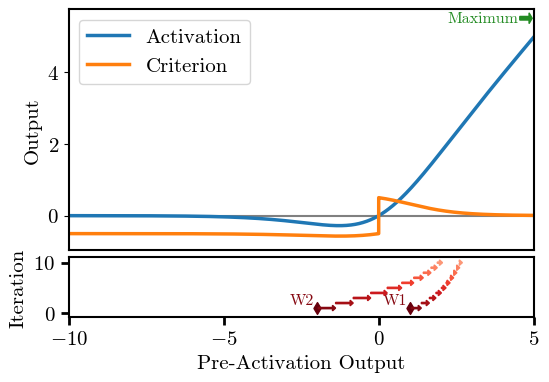

vanilla-gradient maximizesingleneuronloss


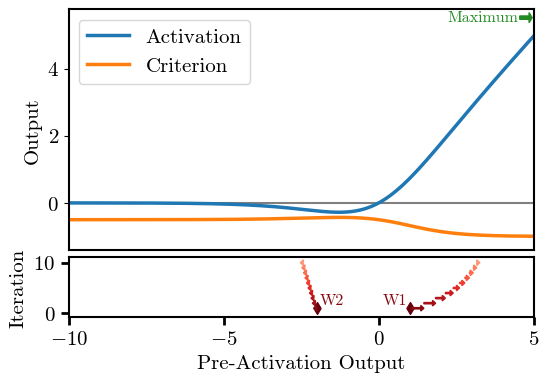

lfp-epsilon minimizesingleneuronreward


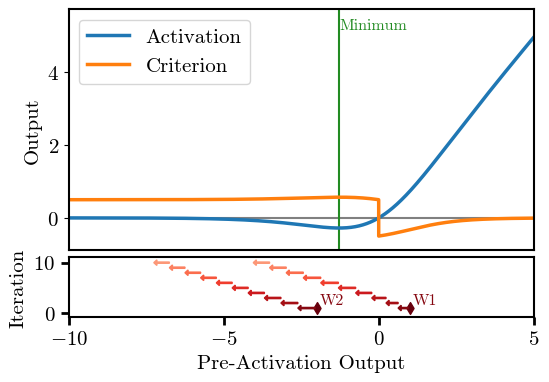

vanilla-gradient minimizesingleneuronloss


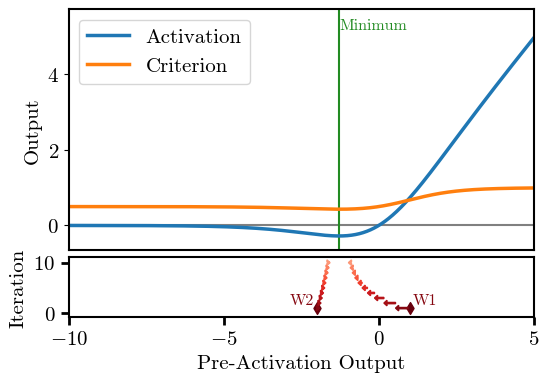

In [13]:
from matplotlib.colors import ListedColormap


def plot_activations_over_epochs(pre_act_output_logs, post_act_output_logs, fname, criterion, colormap="Set1"):
    fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True, height_ratios=[0.8, 0.2])
    fig.subplots_adjust(hspace=0.05)

    xpoints = torch.arange(-10, 5, 0.001)
    ypoints = torch.nn.SiLU()(xpoints.to(device))
    axes[0].plot(
        xpoints.detach().cpu().numpy(),
        ypoints.detach().cpu().numpy(),
        linewidth=2.5,
        alpha=1,
        label="Activation",
    )

    crit = rewards.get_reward(criterion, device)
    cpoints = crit(ypoints, torch.ones_like(ypoints))
    axes[0].plot(
        xpoints.detach().cpu().numpy(),
        cpoints.detach().cpu().numpy(),
        linewidth=2.5,
        alpha=1,
        label="Criterion",
    )

    axes[0].hlines([0], xmin=-100, xmax=100, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)
    ylim = axes[0].get_ylim()
    ylim = (ylim[0] - 0.1, ylim[1] + 0.5)

    if "min" in criterion:
        axes[0].vlines(
            [xpoints[ypoints.argmin().detach().cpu().numpy()]],
            ymin=ylim[0],
            ymax=ylim[1],
            color="forestgreen",
            linewidth=1.5,
            zorder=0,
        )
        axes[0].text(
            xpoints[ypoints.argmin().detach().cpu().numpy()],
            ylim[1] - 0.25,
            "Minimum",
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=11.5,
            color="forestgreen",
        )
    else:
        axes[0].arrow(
            4.5,
            ylim[1] - 0.25,
            0.4,
            0.0,
            color="forestgreen",
            width=0.1,
            head_width=0.3,
            head_length=0.1,
            head_starts_at_zero=True,
            length_includes_head=True,
            zorder=100,
        )
        axes[0].text(
            4.5,
            ylim[1] - 0.25,
            "Maximum",
            horizontalalignment="right",
            verticalalignment="center",
            fontsize=11.5,
            color="forestgreen",
        )

    cmap = cm.get_cmap("Reds", 256)
    newcolors = cmap(np.linspace(0.3, 1.0, 256))
    pastel = 0.0
    newcolors = (1 - pastel) * newcolors + pastel * np.ones((256, 4))
    trainer_cm = ListedColormap(newcolors.clip(max=1)[::-1])

    for w, (pre_act_output_log, post_act_output_log) in enumerate(list(zip(pre_act_output_logs, post_act_output_logs))):
        toplot_idx = np.arange(0, len(pre_act_output_log), 1).astype(int)
        sc = axes[1].scatter(
            pre_act_output_log,
            post_act_output_log,
            c=toplot_idx,
            marker="",
            cmap=trainer_cm,
        )

        for p, pre_val in enumerate(pre_act_output_log):
            if p > 0:
                axes[1].arrow(
                    pre_act_output_log[p - 1][0],
                    p,
                    (pre_act_output_log[p][0] - pre_act_output_log[p - 1][0]),
                    0.0,
                    color=trainer_cm(p / len(pre_act_output_log)),
                    width=0.25,
                    head_width=1.1,
                    head_length=0.1,
                    head_starts_at_zero=True,
                    length_includes_head=True,
                    zorder=100 - p,
                )
            else:
                axes[1].scatter(pre_act_output_log[p], p + 1, c=1, marker="d", cmap=trainer_cm)
                if pre_act_output_log[p + 1] <= pre_act_output_log[p]:
                    axes[1].text(
                        pre_act_output_log[p] + 0.1,
                        p + 1 + 0.1,
                        f"W{w + 1}",
                        horizontalalignment="left",
                        verticalalignment="bottom",
                        fontsize=11.5,
                        color=trainer_cm(1 / len(pre_act_output_log)),
                    )
                else:
                    axes[1].text(
                        pre_act_output_log[p] - 0.1,
                        p + 1 + 0.1,
                        f"W{w + 1}",
                        horizontalalignment="right",
                        verticalalignment="bottom",
                        fontsize=11.5,
                        color=trainer_cm(1 / len(pre_act_output_log)),
                    )

    # cbar = plt.colorbar(sc)
    # cbar.set_label('Iteration')

    axes[0].set_ylim(ylim)
    axes[0].set_ylabel("Output")
    axes[1].xaxis.tick_bottom()
    axes[1].set_ylabel("Iteration")
    axes[1].set_xlabel("Pre-Activation Output")
    # ax.set_ylim([0.3, 1.01])
    # ax.set_yticks([0.4, 0.6, 0.8, 1.0])
    # ax.set_yticklabels([40, 60, 80, 100])
    axes[1].tick_params(length=6, width=2)
    axes[1].set_xticks([-10, -5, 0, 5])
    axes[1].set_xlim([-10, 5])

    axes[0].tick_params(axis="x", length=0, width=0)
    axes[0].legend()
    plt.show()
    fig.savefig(fname)


for r, reward_name in enumerate(reward_names):
    for name in propagation_composites.keys():
        criterion = reward_name if name != "vanilla-gradient" else loss_names[r]
        print(name, criterion)
        plot_activations_over_epochs(
            [tr.pre_act_output_log for tr in trainers[r][name]],
            [tr.post_act_output_log for tr in trainers[r][name]],
            fname=os.path.join(savepath, f"activations-crit-{criterion}-{name}.svg"),
            criterion=criterion,
        )